### Sample program for DCGAN  

#### Import libraries  

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from PIL import Image

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.layers import Reshape, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.datasets import mnist

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
np.random.seed(11)
tf.random.set_seed(13)

#### Parameters  

In [12]:
used_digits = [4,8]
n_data = 1500
n_epoch = 50
n_noise = 100
batch_size = 32

img_dir = 'images'
model_g = 'model_dcgan-b{}_g.h5'.format(batch_size)
model_d = 'model_dcgan-b{}_d.h5'.format(batch_size)

#### Remove old img_dir and create new one  

In [13]:
import shutil, os
if os.path.exists(img_dir):
    shutil.rmtree(img_dir)

cnt = 10
while cnt > 0:
    try:
        os.makedirs(img_dir)
        break
    except:
        sleep(1)
    cnt -= 1
    
if cnt <= 0:
    print('Cannot mkdir:', img_dir)
else:
    print('mkdir: OK')

mkdir: OK


#### Generator  

In [14]:
def generator_model():
    model = Sequential()
    model.add(Dense(256, input_shape=(n_noise, ), activation="tanh"))
    model.add(Dense(32 * 7 * 7))
    model.add(BatchNormalization())
    model.add(Activation("tanh"))
    model.add(Reshape((7, 7, 32), input_shape=(7 * 7 * 32,)))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2D(16, (5, 5),
                     padding="same",
                     activation="tanh",
                     data_format="channels_last"))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2D(1, (5, 5),
                     padding="same",
                     activation="tanh",
                     data_format="channels_last"))
    return model

#### Discriminator  

In [15]:
def discriminator_model():
    model = Sequential()
    model.add(Conv2D(16, (5, 5),
                     padding="same",
                     input_shape=(28, 28, 1),
                     activation="tanh",
                     data_format="channels_last"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (5, 5),
                     activation="tanh",
                     data_format="channels_last"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation="tanh"))
    model.add(Dense(1, activation="sigmoid"))
    return model

#### D(G(z))  

In [16]:
def generator_containing_discriminator(generator, discriminator):
    model = Sequential()
    model.add(generator)
    discriminator.trainable = False
    model.add(discriminator)
    return model

#### For output image samples  

In [17]:
def combine_images(generated_images):
    generated_images = generated_images.reshape(generated_images.shape[0],
                                                generated_images.shape[3],
                                                generated_images.shape[1],
                                                generated_images.shape[2])
    num = generated_images.shape[0]
    width = int(math.sqrt(num))
    height = int(math.ceil(float(num) / width))
    shape = generated_images.shape[2:]
    image = np.zeros((height*shape[0], width*shape[1]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
            img[0, :, :]
    return image

#### Training (learning)  

In [18]:
def train(BATCH_SIZE):
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    X_train = X_train[ np.isin(y_train, used_digits) ]
    y_train = y_train[ np.isin(y_train, used_digits) ]
    X_train = X_train[:n_data]
    y_train = y_train[:n_data]
    X_train = (X_train.astype(np.float32) - 127.5)/127.5
    X_train = X_train.reshape((X_train.shape[0], 1) + X_train.shape[1:])
    discriminator = discriminator_model()
    generator = generator_model()
    discriminator_on_generator = \
        generator_containing_discriminator(generator, discriminator)
    #d_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
    #g_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
    #generator.compile(loss="binary_crossentropy", optimizer="SGD")
    d_optim = Adam()
    g_optim = Adam()
    generator.compile(loss="binary_crossentropy", optimizer="Adam")
    discriminator_on_generator.compile(
        loss="binary_crossentropy", optimizer=g_optim)
    discriminator.trainable = True
    discriminator.compile(loss="binary_crossentropy", optimizer=d_optim)
    noise = np.zeros((BATCH_SIZE, n_noise))
    ret = []
    for epoch in range(n_epoch):
        print("Epoch is", epoch)
        print("Number of batches", int(X_train.shape[0]/BATCH_SIZE))
        n_index = int(X_train.shape[0]/BATCH_SIZE)
        for index in range(n_index):
            for i in range(BATCH_SIZE):
                noise[i, :] = np.random.uniform(-1, 1, n_noise)
            image_batch = X_train[index*BATCH_SIZE:(index+1)*BATCH_SIZE]
            image_batch = image_batch.reshape(image_batch.shape[0],
                                              image_batch.shape[2],
                                              image_batch.shape[3],
                                              image_batch.shape[1])
            generated_images = generator.predict(noise, verbose=0)
            if (epoch == 0 and index == 0) or index == (n_index-1):
                image = combine_images(generated_images)
                image = image*127.5+127.5
                img_file = str(epoch)+"_"+str(index)+".png"
                img_file = os.path.join(img_dir, img_file)
                Image.fromarray(image.astype(np.uint8)).save(img_file)

            X = np.concatenate((image_batch, generated_images))
            y = [1] * BATCH_SIZE + [0] * BATCH_SIZE
            d_loss = discriminator.train_on_batch(X, y)
            for i in range(BATCH_SIZE):
                noise[i, :] = np.random.uniform(-1, 1, n_noise)
            discriminator.trainable = False
            g_loss = discriminator_on_generator.train_on_batch(
                noise, [1] * BATCH_SIZE)
            discriminator.trainable = True
            loss_msg = "batch {:d}  d_loss: {:f}".format(index, d_loss)
            loss_msg += "  g_loss: {:f}".format(g_loss)
            print(loss_msg)
            ret.append((epoch, index, d_loss, g_loss))
            if index % 10 == 9:
                generator.save_weights("generator", True)
                discriminator.save_weights("discriminator", True)
                
    generator.save(model_g)
    discriminator.save(model_d)
    return ret

#### Generate images using generator  

In [19]:
def generate(BATCH_SIZE):
    generator = generator_model()
    #generator.compile(loss="binary_crossentropy", optimizer="SGD")
    generator.compile(loss="binary_crossentropy", optimizer="Adam")
    generator.load_weights("generator")
    noise = np.zeros((BATCH_SIZE, n_noise))
    for i in range(BATCH_SIZE):
        noise[i, :] = np.random.uniform(-1, 1, n_noise)
    generated_images = generator.predict(noise, verbose=1)
    image = combine_images(generated_images)
    image = image*127.5+127.5
    Image.fromarray(image.astype(np.uint8)).save("generated_image.png")

#### Do training (learning)  

In [20]:
%%time

train_log = train(BATCH_SIZE=batch_size)

Epoch is 0
Number of batches 46
batch 0  d_loss: 0.907354  g_loss: 0.345442
batch 1  d_loss: 0.561648  g_loss: 0.317500
batch 2  d_loss: 0.579032  g_loss: 0.494862
batch 3  d_loss: 0.462686  g_loss: 0.945871
batch 4  d_loss: 0.349043  g_loss: 1.732489
batch 5  d_loss: 0.250366  g_loss: 2.859324
batch 6  d_loss: 0.180040  g_loss: 3.796990
batch 7  d_loss: 0.212602  g_loss: 4.314776
batch 8  d_loss: 0.131865  g_loss: 4.835903
batch 9  d_loss: 0.126713  g_loss: 5.069409
batch 10  d_loss: 0.084639  g_loss: 5.593263
batch 11  d_loss: 0.246620  g_loss: 5.988260
batch 12  d_loss: 0.419414  g_loss: 7.142318
batch 13  d_loss: 0.236809  g_loss: 7.464239
batch 14  d_loss: 0.258980  g_loss: 7.698951
batch 15  d_loss: 0.358742  g_loss: 7.556085
batch 16  d_loss: 0.886415  g_loss: 6.477520
batch 17  d_loss: 0.781369  g_loss: 5.480601
batch 18  d_loss: 0.704438  g_loss: 4.591381
batch 19  d_loss: 0.784443  g_loss: 3.719917
batch 20  d_loss: 0.409291  g_loss: 3.562066
batch 21  d_loss: 0.349305  g_los

#### Check train_log  

In [21]:
df_fit = pd.DataFrame(train_log)
df_fit.columns = ['epoch', 'batch', 'd_loss', 'g_loss']
display(df_fit.head())
display(df_fit.tail())

,epoch,batch,d_loss,g_loss
0,0,0,0.907354,0.345442
1,0,1,0.561648,0.317500
2,0,2,0.579032,0.494862
3,0,3,0.462686,0.945871
4,0,4,0.349043,1.732489


,epoch,batch,d_loss,g_loss
2295,49,41,0.481548,2.181650
2296,49,42,0.341456,2.292595
2297,49,43,0.414084,1.623359
2298,49,44,0.380532,1.484777
2299,49,45,0.424270,1.271540


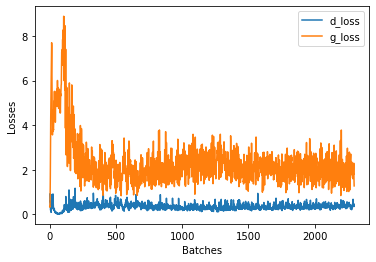

In [22]:
plt.plot(df_fit.index, df_fit['d_loss'], label='d_loss')
plt.plot(df_fit.index, df_fit['g_loss'], label='g_loss')
plt.xlabel('Batches')
plt.ylabel('Losses')
plt.legend()
plt.show()

#### Generate image by using Generator  

In [23]:
generate(batch_size)

/home/anhvu/.local/lib/python3.9/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
